# Test Notebook
The circle / common tangent problem is pretty hard. I use this notebook to test ideas for solving this before I impliment them into c++

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy

In [2]:
layer = np.array([0,1,2,3,4,5,6,7])
wire = np.array([2,2,2,2,2,2,2,2])
tdc = np.array([9,190,59,121,129,51,198,17])
DIVIDER = 900

In [3]:
def conv_hit_to_coords(l : np.array, w : np.array):
    # if l is odd, add 0.5 to it
    x = l
    y = w+ 0.5*(l%2)
    return (x, y)


def get_basic_plot():
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    for i in range(8):
        for j in range(8):
            x, y = conv_hit_to_coords(i,j)
            ax.plot(x, y, 'k.')

    x, y = conv_hit_to_coords(layer, wire)
    ax.plot(x, y, 'rx')
    ax.set(xlabel='Layer', ylabel='Wire',)
    return ax

def plot_TDC_circles(ax, v=1):
    
    for i in range(8):
        x, y = conv_hit_to_coords(layer[i], wire[i])
        ax.add_artist(plt.Circle((x,y), tdc[i] / DIVIDER * v, color='b', fill=False))
    
    return ax

<Axes: xlabel='Layer', ylabel='Wire'>

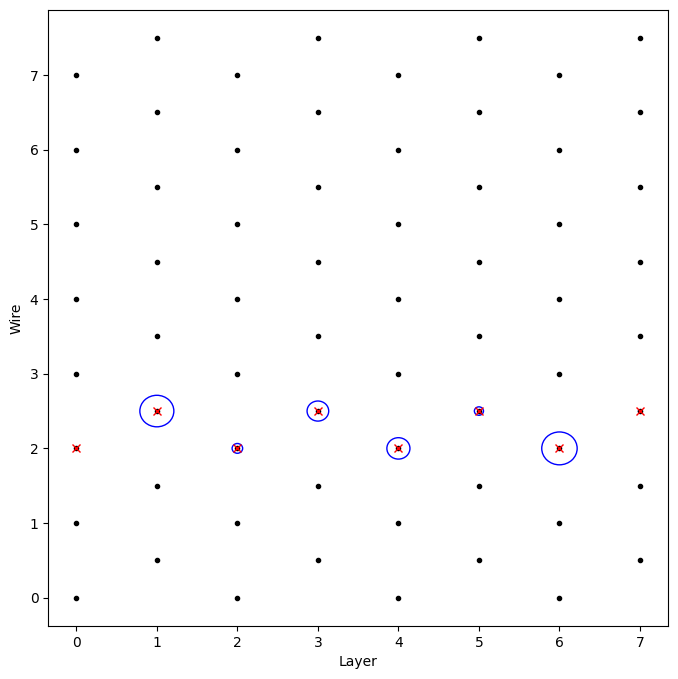

In [4]:
plot_TDC_circles(get_basic_plot())

In [5]:
# ax + bY + c = 0
class line:
    def __init__(self, a , b, c):
        self.a = a
        self.b = b
        self.c = c
    
    def plot(self, ax, xmin, xmax):
        x = np.linspace(xmin, xmax, 100)
        y = (-self.a * x - self.c) / self.b
        ax.plot(x, y)
        return ax

class circle:
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
    
    def plot(self, ax):
        ax.add_artist(plt.Circle((self.x, self.y), self.r, color='b', fill=False))
        return ax

def get_tangents_to_two_circles(c1, c2):
    ls = []

    # four solutions
    for i in [-1, 1]:
        for j in [-1, 1]:
            r1 = c1.r * i
            r2 = c2.r * j

            dr = r2 - r1

            x = c2.x - c1.x
            y = c2.y - c1.y

            z = x**2 + y**2
            d = np.sqrt( np.abs(z - dr**2) )

            a = (x * dr + y*d)/z
            b = (y * dr - x*d)/z
            c = r1 - c1.x * a - c1.y * b

            l = line(a, b, c)  
            ls.append(l) 

    return ls

28


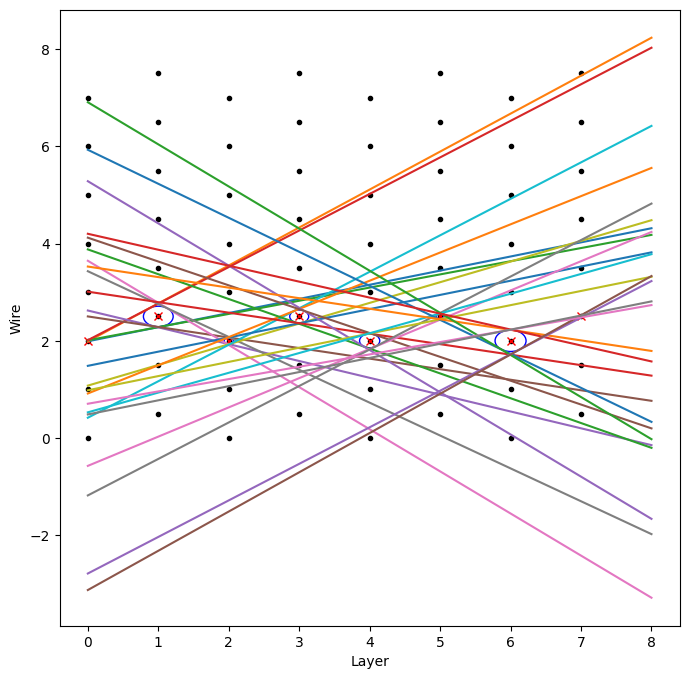

In [6]:
lsarr = []
for i in range(7):
    c1 = circle(conv_hit_to_coords(layer[i], wire[i])[0], conv_hit_to_coords(layer[i], wire[i])[1], tdc[i] / DIVIDER)
    #c1.plot(get_basic_plot())

    c2 = circle(conv_hit_to_coords(layer[i+1], wire[i+1])[0], conv_hit_to_coords(layer[i+1], wire[i+1])[1], tdc[i+1] / DIVIDER)
    #c2.plot(get_basic_plot())

    lsarr.append(get_tangents_to_two_circles(c1, c2))

ax = plot_TDC_circles(get_basic_plot())
for ls in lsarr:
    for l in ls:
        #print(l.a, l.b, l.c)
        ax = l.plot(ax, 0, 8)
print(len(lsarr) * 4)
plt.show()

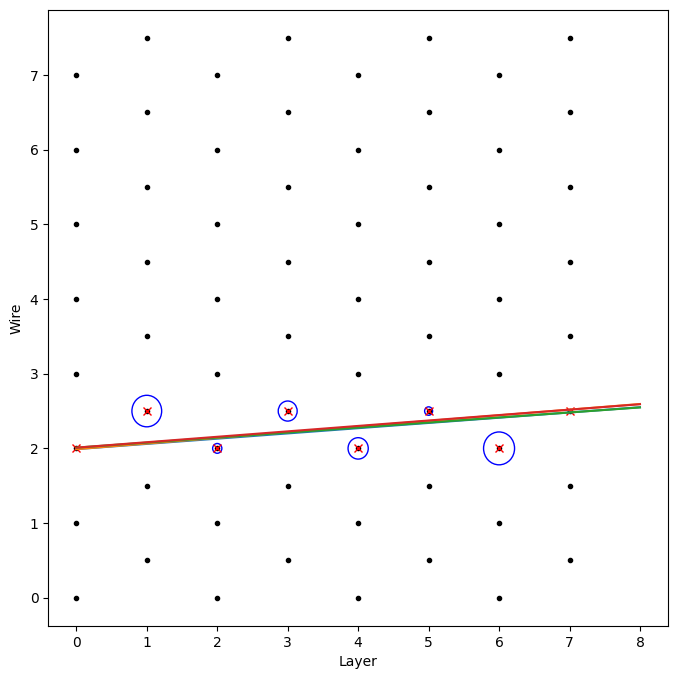

In [7]:
# first and last circle
c1 = circle(conv_hit_to_coords(layer[0], wire[0])[0], conv_hit_to_coords(layer[0], wire[0])[1], tdc[0] / DIVIDER)
c2 = circle(conv_hit_to_coords(layer[7], wire[7])[0], conv_hit_to_coords(layer[7], wire[7])[1], tdc[7] / DIVIDER)

ls = get_tangents_to_two_circles(c1, c2)
ax = plot_TDC_circles(get_basic_plot())
for l in ls:
    ax = l.plot(ax, 0, 8)
plt.show()

In [8]:
# now do minimisation until all 8 circles touch ONE of these tangent lines
from scipy.optimize import minimize

# check if a cirlce is touching a line
def min_circle_line_dist(c, l):
    return np.abs(l.a * c.x + l.b * c.y + l.c) / np.sqrt(l.a**2 + l.b**2) - c.r

def f(v):
    # drifttime * v = radius

    c1 = circle(conv_hit_to_coords(layer[0], wire[0])[0], conv_hit_to_coords(layer[0], wire[0])[1], tdc[0] / DIVIDER * v)
    c2 = circle(conv_hit_to_coords(layer[7], wire[7])[0], conv_hit_to_coords(layer[7], wire[7])[1], tdc[7] / DIVIDER * v)
    ls = get_tangents_to_two_circles(c1, c2)
    return check_all_lines(ls, v)


def check_all_lines(ls, v):
    dist = np.array([])
    
    for l in ls:

        for i in range(1,6): # dont need to check the first and last circle
            # check if the circle is touching the line
            c = circle(conv_hit_to_coords(layer[i], wire[i])[0], conv_hit_to_coords(layer[i], wire[i])[1], tdc[i] / DIVIDER * v)
            dist = np.append(dist, min_circle_line_dist(c, l))
        
        # we want to minimise it such that all distances are < 0.001
    total_dist = np.sum(np.abs(dist))
    return total_dist # wanna minimise this!




res = minimize(f, 2, method='Nelder-Mead')
print(res.x)

[2.08154297]


In [9]:
#%%timeit
minimize(f, 1, method='Nelder-Mead')

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.4097009977480601
             x: [ 2.082e+00]
           nit: 17
          nfev: 34
 final_simplex: (array([[ 2.082e+00],
                       [ 2.081e+00]]), array([ 4.097e-01,  4.097e-01]))

In [10]:
v = res.x / DIVIDER
print(v)

[0.00231283]


In [11]:
8 / 1000 * 1_000_000

8000.0

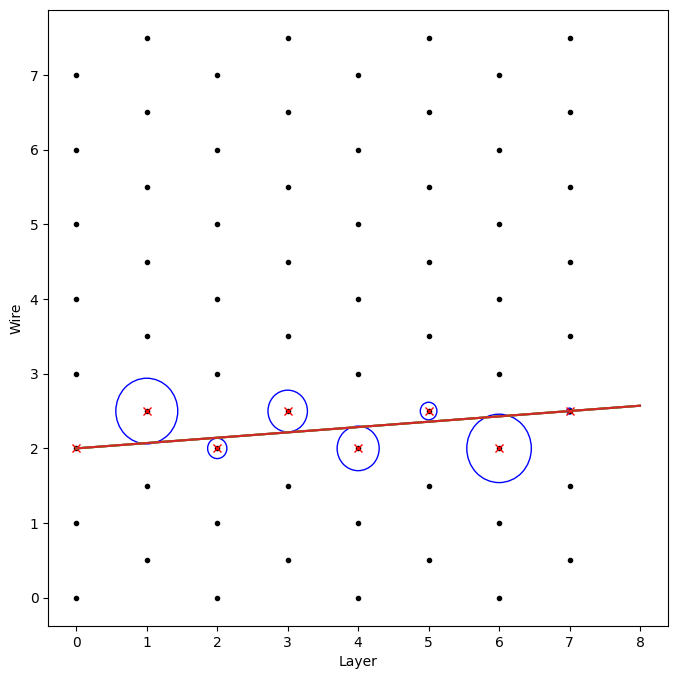

In [12]:
ax = plot_TDC_circles(get_basic_plot(), res.x)
# get the tangent to the first and last circle
c1 = circle(conv_hit_to_coords(layer[0], wire[0])[0], conv_hit_to_coords(layer[0], wire[0])[1], tdc[0] / DIVIDER * v)
c2 = circle(conv_hit_to_coords(layer[7], wire[7])[0], conv_hit_to_coords(layer[7], wire[7])[1], tdc[7] / DIVIDER * v)
ls = get_tangents_to_two_circles(c1, c2)
for l in ls:
    ax = l.plot(ax, 0, 8)

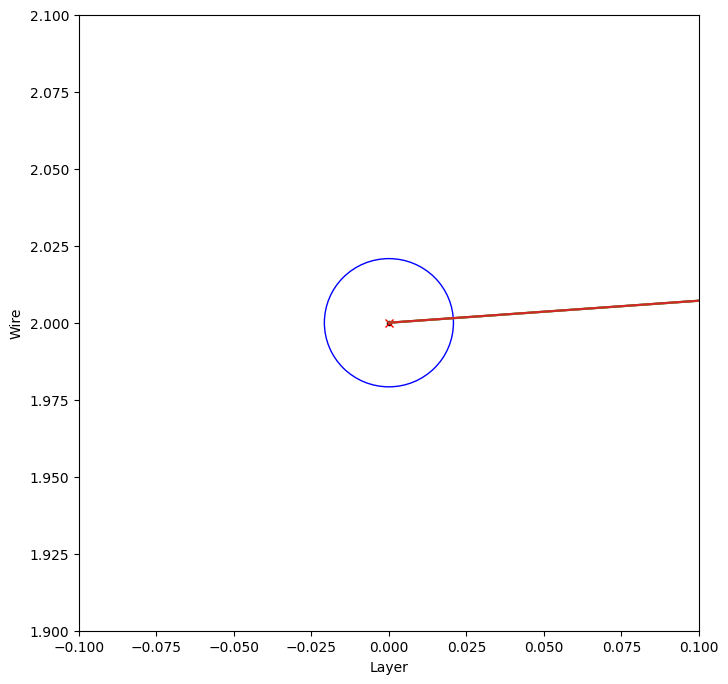

In [13]:
# CHECK IT WORKS - ZOOM IN TO FIRST CIRCLE

ax = plot_TDC_circles(get_basic_plot(), res.x)
# get the tangent to the first and last circle
c1 = circle(conv_hit_to_coords(layer[0], wire[0])[0], conv_hit_to_coords(layer[0], wire[0])[1], tdc[0] / DIVIDER * v)
c2 = circle(conv_hit_to_coords(layer[7], wire[7])[0], conv_hit_to_coords(layer[7], wire[7])[1], tdc[7] / DIVIDER * v)
ls = get_tangents_to_two_circles(c1, c2)
for l in ls:
    ax = l.plot(ax, 0, 8)

ax.set_xlim(-0.1, 0.1)
ax.set_ylim(1.9,2.1)
plt.show()

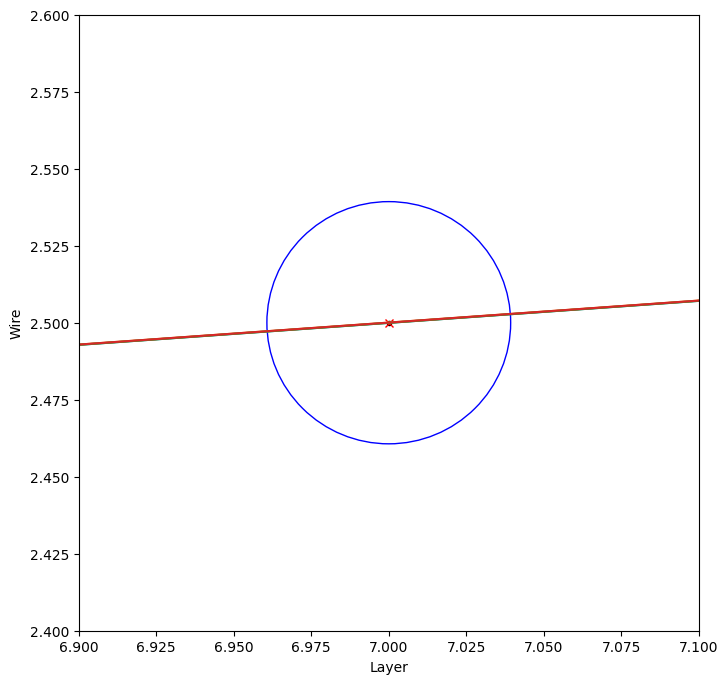

In [14]:
ax = plot_TDC_circles(get_basic_plot(), v*DIVIDER)
# get the tangent to the first and last circle
c1 = circle(conv_hit_to_coords(layer[0], wire[0])[0], conv_hit_to_coords(layer[0], wire[0])[1], tdc[0] / DIVIDER * v)
c2 = circle(conv_hit_to_coords(layer[7], wire[7])[0], conv_hit_to_coords(layer[7], wire[7])[1], tdc[7] / DIVIDER * v)
ls = get_tangents_to_two_circles(c1, c2)
for l in ls:
    ax = l.plot(ax, 0, 8)

ax.set_xlim(6.9, 7.1)
ax.set_ylim(2.4,2.6)
plt.show()

(1.99, 2.01)

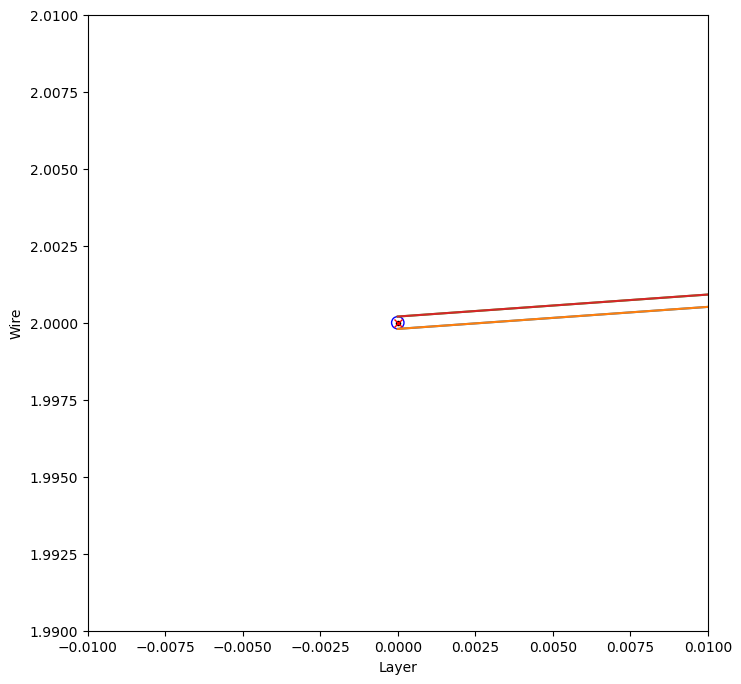

In [15]:
ax = plot_TDC_circles(get_basic_plot(), v=0.02)
# get the tangent to the first and last circle
c1 = circle(conv_hit_to_coords(layer[0], wire[0])[0], conv_hit_to_coords(layer[0], wire[0])[1], tdc[0] / DIVIDER*0.02)
c2 = circle(conv_hit_to_coords(layer[7], wire[7])[0], conv_hit_to_coords(layer[7], wire[7])[1], tdc[7] / DIVIDER*0.02)
ls = get_tangents_to_two_circles(c1, c2)
for l in ls:
    ax = l.plot(ax, 0, 8)
ax.set_xlim(-0.01, 0.01)
ax.set_ylim(1.99,2.01)
